## Loan Default Prediction:  modelling based upon consumer data

## Introduction

    The aftermath of the 2008 subprime mortgage crisis has caused huge damages to world economy and society. It raises importance of retail credit for consumers. Using Data Science, Data Mining, Exploratory Data Analysis and Machine Learning, we will investigate the issue in detail and try to predict if an individual is likely to default on a loan or not. 

[Google Slides Presentation Link](https://docs.google.com/presentation/d/1RwfTxwPwXFyIjojebhE7_kOv41Tkx4n1wpRNcHcjkw8/edit#slide=id.g723630543_3_0)



## Research Questions

    Based upon data, can the model predict whether one loan will default or not?
    
  

## Models

    Three models will be used, Decision Tree, Random Forest & Boosting Classifier.

In [49]:
import numpy as np
import pandas as pd
import scipy
import math
from decimal import Decimal
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# decision tree
from sklearn import tree
# A convenience for displaying visualizations.
from IPython.display import Image
# Packages for rendering our tree.
import pydotplus
#import graphviz

# linear regression model
from sklearn import linear_model

# SVC
from sklearn import ensemble
from sklearn.svm import SVC

## Setup utility functions 

In [50]:
# convert alphabetic grades to numerical ones
#      A    B    C    D    E    F    G
#      1    2    3    4    5    6    7
def grade_from_alphabet_to_numeric(x):
    grade_map = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
    try:
        return grade_map[str(x)]
    except KeyError:
        return Decimal('nan')

In [51]:
# convert string emp_length to numerical ones
#  
def convert_emp_length_to_numeric(x):
    x_tmp = str(x).split(' ')[:-1]
    x_new = str(x_tmp[0])
    if len(x_tmp) > 1:
        x_new = x_new + ' ' + x_tmp[1]
    
    conv_map = {'<1':1, '1':2, '2':3, '3':4, '4':5, '5':6, '6':7, '7':8, '8':9, '9':10, '10':11, '10+':12}
    try:
        return conv_map[str(x_new)]
    except:
        return Decimal('nan')

In [52]:
# convert string home_ownership to numerical ones
#       'OWN', 'MORTGAGE', 'RENT', 'OTHER', 'NONE'
#        1      2           3      4        5
def convert_home_ownership_to_numeric(x):
    conv_map = {'OWN':1, 'MORTGAGE':2, 'RENT':3, 'OTHER':4, 'NONE':5}
    try:
        return conv_map[str(x)]
    except:
        return Decimal('nan')

In [53]:
# convert string verification to numerical numbers
#               'Source Verified'   'Verified'   'nOT Verified'
#               1                   2           3
def convert_verification_to_numeric(x):
    conv_map = {'Source Verified':1, 'Verified':2, 'Not Verified':3}
    try:
        return conv_map[str(x)]
    except:
        return Decimal('nan')

In [54]:
# split dataset into train & test
def train_test_dataset(x, size, ran):
    x_train, x_test = train_test_split(x, test_size=size, random_state=ran)
    return x_train, x_test

## readin dataset

In [55]:
df_0 = pd.read_csv('../../data-201-resources-master/LendingClub/LoanStats3a_new.csv')
df_0.head()

,Unnamed: 0,Unnamed: 0.1,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,...,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
0,0,NaN,0,NaN,AZ,NaN,24000.0,NaN,Individual,NaN,...,5863.155187,5833.84,863.16,0.00,5000.00,NaN,NaN,Verified,NaN,860xx
1,1,NaN,0,NaN,GA,NaN,30000.0,NaN,Individual,NaN,...,1014.530000,1014.53,435.17,0.00,456.46,NaN,NaN,Source Verified,NaN,309xx
2,2,NaN,0,NaN,IL,NaN,12252.0,NaN,Individual,NaN,...,3005.666844,3005.67,605.67,0.00,2400.00,NaN,NaN,Not Verified,NaN,606xx
3,3,NaN,0,NaN,CA,NaN,49200.0,NaN,Individual,NaN,...,12231.890000,12231.89,2214.92,16.97,10000.00,NaN,NaN,Source Verified,NaN,917xx
4,4,NaN,0,NaN,OR,NaN,80000.0,NaN,Individual,NaN,...,4066.908161,4066.91,1066.91,0.00,3000.00,NaN,NaN,Source Verified,NaN,972xx


## dataset imbalance

    The dataset above has 86% data for class 0 and 14% for class 1. To mitigate dataset imbalance, additional data
    are added.


In [56]:
df_1 = pd.read_csv('../../data-201-resources-master/LendingClub/LoanStats3e.csv')
df_2 = pd.read_csv('../../data-201-resources-master/LendingClub/LoanStats3f.csv')
df = pd.DataFrame()
df = df_0
df = df.append(df_1, axis=1)
df = df.append(df_2, axis=2)

## Cleaning dataset:    
            (1) drop unnecessary columns    
            (2) drop NaN values
            (3) convert remaining columns to numeric for models

In [57]:
# Below are the columns important for this analysis
X = pd.DataFrame()
X['loan_amnt'] = df['loan_amnt']
#X['funded_amnt_inv'] = df['funded_amnt_inv']
X['term'] = df['term']
X['int_rate'] = df['int_rate']
X['installment'] = df['installment']
X['grade'] = df['grade']
X['sub_grade'] = df['sub_grade']
X['emp_length'] = df['emp_length']
X['home_ownership'] = df['home_ownership']
X['annual_inc'] = df['annual_inc']
X['verification_status'] = df['verification_status']
#X['purpose'] = df['purpose']
X['inq_last_6mths'] = df['inq_last_6mths']
X['last_pymnt_amnt'] = df['last_pymnt_amnt']
X['loan_status'] = df['loan_status']

X = X.dropna()
# reset index
X.reset_index(drop=True, inplace=True)

##  Feature Engineering

    Changing variables types into numeric.

    


In [58]:
# convert column value to numeric
# strip off 'months'
X['term'] = X['term'].apply(lambda x: int(str(x)[:-7]))
# strip off '%'
X['int_rate'] = X['int_rate'].apply(lambda x: float(str(x)[:-1]))
X['grade'] = X['grade'].apply(lambda x: grade_from_alphabet_to_numeric(x))
# strip grade alphabet from subgrade
X['sub_grade'] = X['sub_grade'].apply(lambda x: int(str(x)[1:]))
X['emp_length'] = X['emp_length'].apply(lambda x: convert_emp_length_to_numeric(x))
X['home_ownership'] = X['home_ownership'].apply(lambda x: convert_home_ownership_to_numeric(x))
X['verification_status'] = df['verification_status'].apply(lambda x: convert_verification_to_numeric(x))
X['loan_status'] = X['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

## Performing Features' Selection

In [59]:
# if any feature has too small variance
selection = VarianceThreshold(threshold=(0.9*(1-0.9)))
X_tmp = selection.fit_transform(X)
print(X.shape)
print(X_tmp.shape)

(71348, 13)
(71348, 13)


##   visualizing data

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


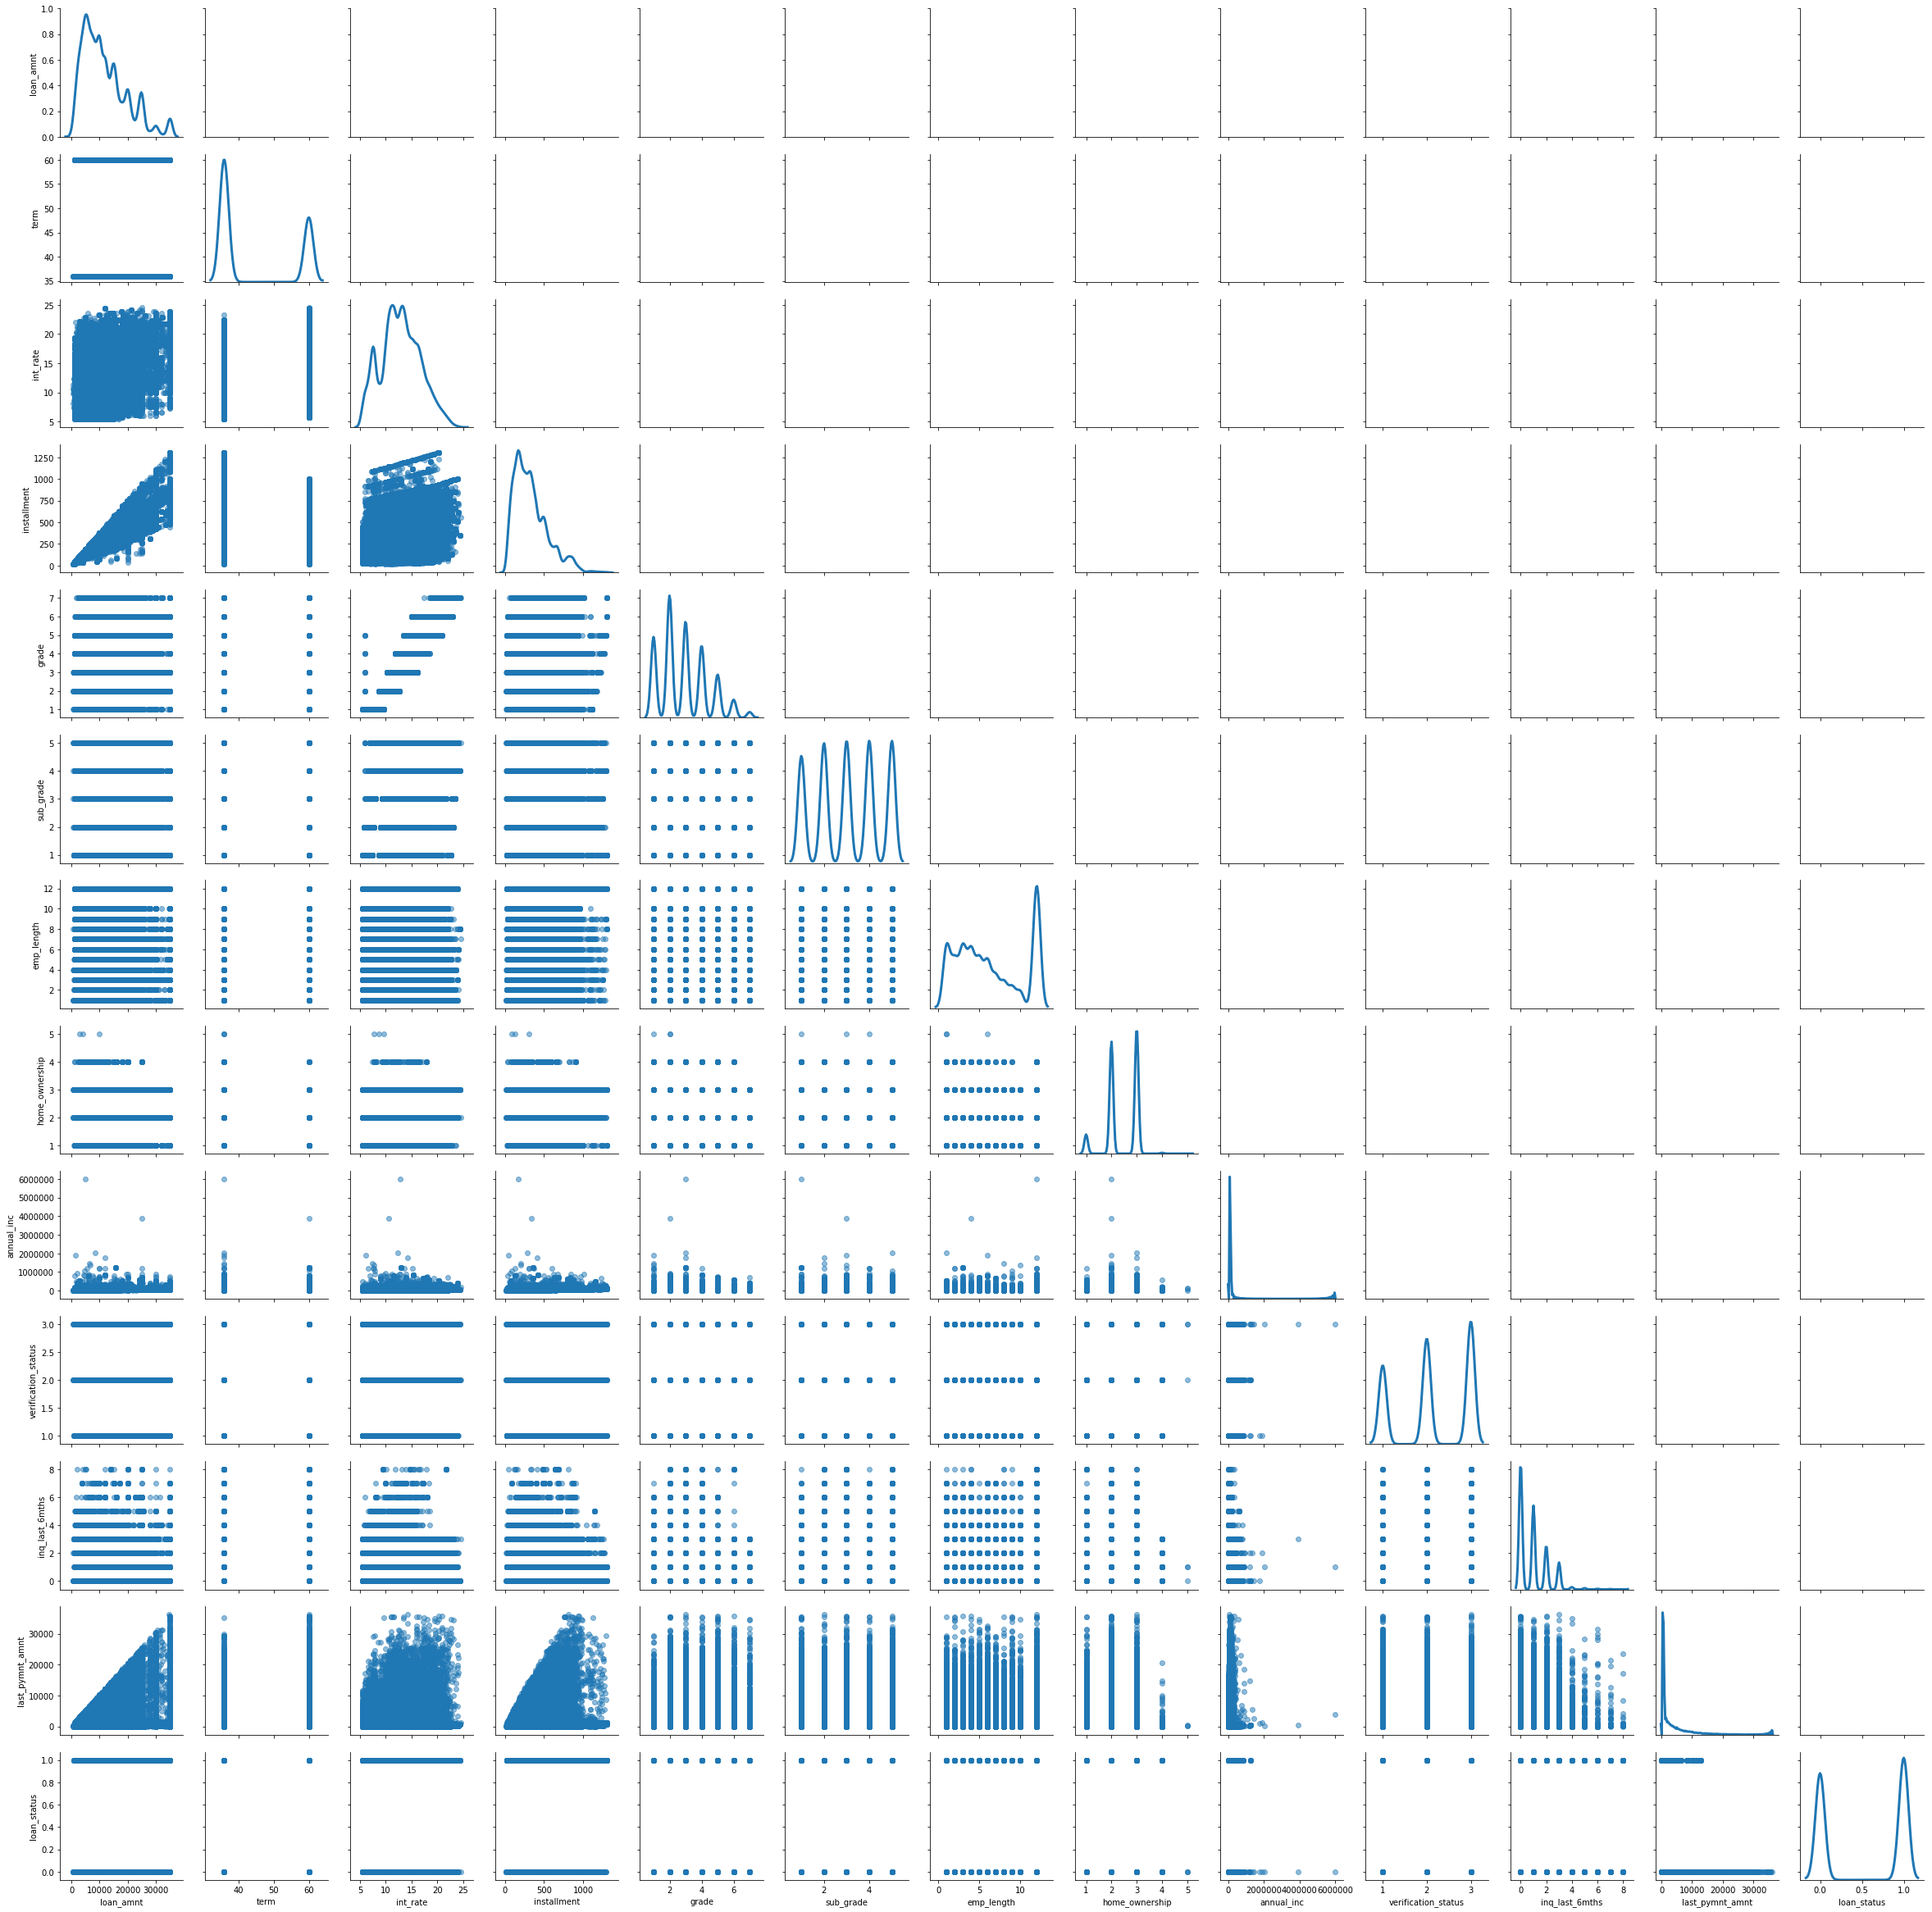

In [60]:
# making scatter plots
graph = sns.PairGrid(X, diag_sharey=False)
# upper right scatter plots
graph.map_lower(plt.scatter, alpha=0.5)
# lower left linear regression fit plots
#graph.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# diagonal variables' univariate distributions
graph.map_diag(sns.kdeplot, lw=3)
plt.show()

## Further Feature Engineering

from the above scatter plots, several variables, i.e. annual_inc, last_pymnt_amnt, home_ownership etc., show 
differentiating capabilities over two classes of loan_status.


In [61]:
# two additional features are added, i.e. last_pymnt_amnt/annual_inc, & installation/loan_amnt
X['loan_pymnt_percent'] = X['last_pymnt_amnt'] / X['annual_inc']
X['install_percent'] = X['installment'] / X['loan_amnt']

# less important columns are dropped
X.drop(['int_rate'], axis=1, inplace=True)
X.drop(['verification_status'], axis=1, inplace=True)
X.drop(['inq_last_6mths'], axis=1, inplace=True)
X.drop(['last_pymnt_amnt'], axis=1, inplace=True)
X.drop(['installment'], axis=1, inplace=True)
X.drop(['annual_inc'], axis=1, inplace=True)

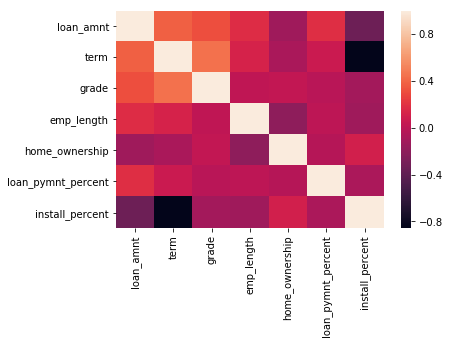

In [63]:
# Looking at the correlation of features
features = pd.DataFrame()
features['loan_amnt'] = X['loan_amnt']
features['term'] = X['term']
features['grade'] = X['grade']
features['emp_length'] = X['emp_length']
features['home_ownership'] = X['home_ownership']
features['loan_pymnt_percent'] = X['loan_pymnt_percent']
features['install_percent'] = X['install_percent']

# coorelation matrix
corr = features.corr()
sns.heatmap(corr)
plt.show()

##  Here to build classifier models

1) Decision tree model

2) Random Forest model

3) gradient boosting classifier model        
    

In [64]:
# target data
Y = pd.DataFrame()
Y['loan_status'] = X['loan_status']

X = X.drop(['loan_status'], axis=1)

In [65]:
# build train & test dataset
trainSize = int(0.65*(X.shape[0]))
X_train, X_test = train_test_dataset(X, trainSize, 1574)
Y_train, Y_test = train_test_dataset(Y, trainSize, 2916)

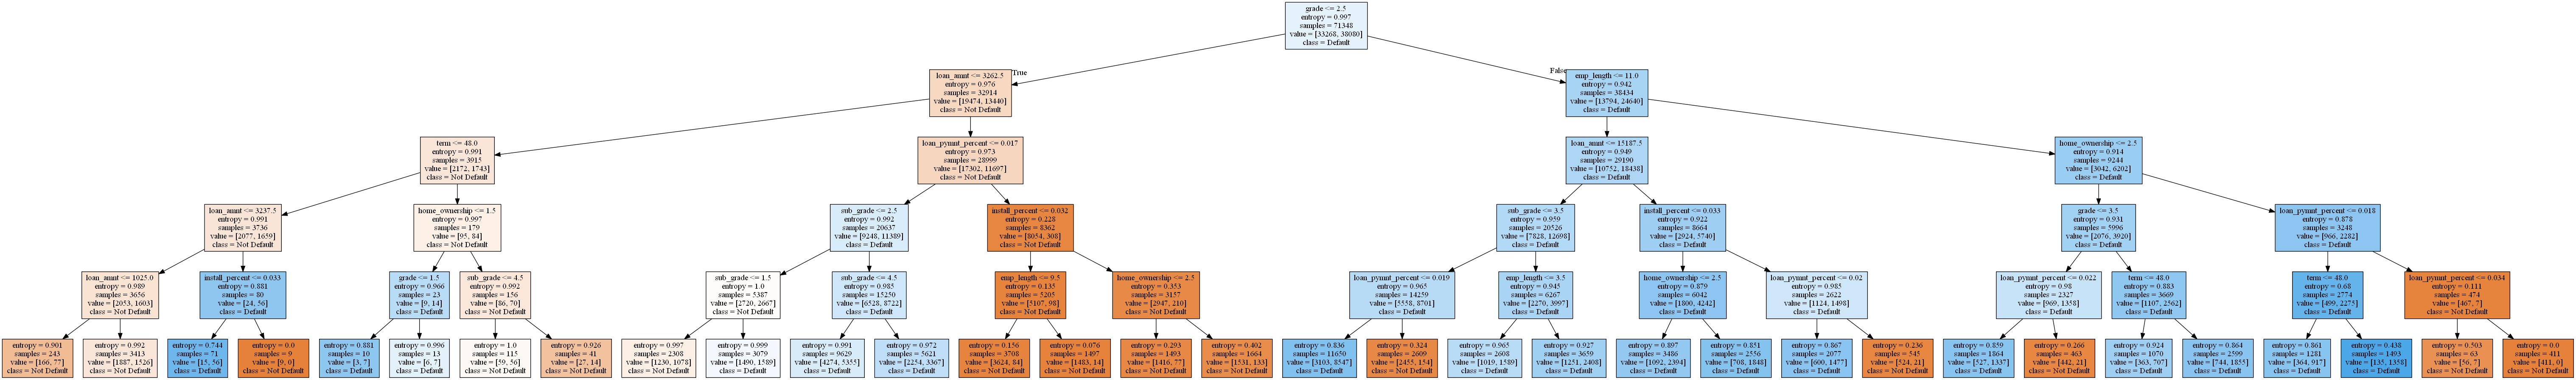

In [72]:
# use decision tree model
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    min_samples_split=3,
    min_samples_leaf=1,
    max_depth=5,
    random_state = 2039
)
decision_tree.fit(X, Y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_train.columns,
    class_names=['Not Default', 'Default'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [73]:
print('Train dataset decision tree score = {}'.format(decision_tree.score(X_train, Y_train)))
print('Test dataset decision tree score = {}'.format(decision_tree.score(X_test, Y_test)))

Train dataset decision tree score = 0.5170190613487106
Test dataset decision tree score = 0.5162368466448163


In [74]:
cross_val_score(decision_tree, X_train, Y_train, cv=5)

array([0.53353353, 0.53293293, 0.5288346 , 0.53444133, 0.53524229])

In [76]:
#out_mat = confusion_matrix(Y_train, decision_tree.predict(X_train))
print(out_mat)
print('accuracy = {}'.format((out_mat[0, 0] / (out_mat[0, 0] + out_mat[0, 1]))))
print('typeI error = {}'.format((out_mat[0, 1] / (out_mat[0, 0] + out_mat[0, 1]))))
print('typeII error = {}'.format((out_mat[1, 0] / (out_mat[1, 0] + out_mat[1, 1]))))
print('specificity = {}'.format((out_mat[1, 1] / (out_mat[1, 0] + out_mat[1, 1]))))

[[6016 5620]
 [6574 6760]]
accuracy = 0.5170161567548985
typeI error = 0.4829838432451014
typeII error = 0.4930253487325634
specificity = 0.5069746512674367


## Several Parameters are used to tune Decision Tree Model

The below spreadsheet summarizes the results

parameters	max_features	max_depth	min_samples_split	min_samples_leaf	SCORE	ACCURACY

        	1	           4	        2	               1	                0.516	0.47
    
            1	           5	        2	               1	                0.497	0.46
    
         	1	           5	        3	               1	                0.517	0.48
    
        	3	           5	        2	               1	                0.453	0.47

The displayed model result is the best performer.

## Random Forest Model

In [77]:
# use Random Forest model
rfc = ensemble.RandomForestClassifier(
    min_samples_split=2,
    min_samples_leaf =1)

X = pd.get_dummies(X)
rfc.fit(X, Y)
print('Train Dataset score {}'.format(rfc.score(X_train, Y_train)))
print('Test Dataset score {}'.format(rfc.score(X_test, Y_test)))
cross_val_score(rfc, X_train, Y_train, cv=4)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Train Dataset score 0.5055662341822842
Test Dataset score 0.5043341383474211


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y wa

array([0.49951954, 0.50408457, 0.49703668, 0.50993271])

In [78]:
out_mat = confusion_matrix(Y_train, rfc.predict(X_train))
print(out_mat)
print('accuracy = {}'.format((out_mat[0, 0] / (out_mat[0, 0] + out_mat[0, 1]))))
print('typeI error = {}'.format((out_mat[0, 1] / (out_mat[0, 0] + out_mat[0, 1]))))
print('typeII error = {}'.format((out_mat[1, 0] / (out_mat[1, 0] + out_mat[1, 1]))))
print('specificity = {}'.format((out_mat[1, 1] / (out_mat[1, 0] + out_mat[1, 1]))))

[[5496 6141]
 [6206 7129]]
accuracy = 0.4722866718226347
typeI error = 0.5277133281773653
typeII error = 0.4653918260217473
specificity = 0.5346081739782527


## Gradient Boosting Classifier Model

Weak model 0 score 0.5104116610603876 for train
Weak model 0 score 0.5098111091944109 for test
Weak model 20 score 0.46600192215281117 for train
Weak model 20 score 0.4664265999654994 for test
Weak model 40 score 0.46600192215281117 for train
Weak model 40 score 0.4664265999654994 for test
Weak model 60 score 0.46600192215281117 for train
Weak model 60 score 0.4664265999654994 for test
Weak model 80 score 0.46600192215281117 for train
Weak model 80 score 0.4664265999654994 for test
Weak model 100 score 0.46600192215281117 for train
Weak model 100 score 0.4664265999654994 for test


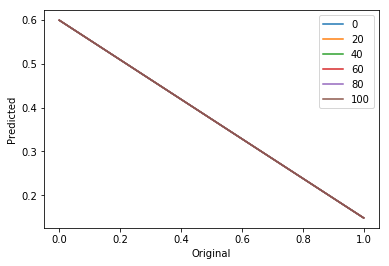

Overall score:
[[ 1.         -0.45057288]
 [-0.45057288  1.        ]]


In [80]:
# use gradient boosting classifier model
predicts = pd.DataFrame()
labels = []

uniquex = Y['loan_status'].unique()

# Iterate through decision trees, each time using the residuals
# from the previous tree as the inputs.
for m in range(0, 101):     
    
    dec_tree = tree.DecisionTreeClassifier(max_depth=3)
    dec_tree.fit(X, Y)
    
    # retrieve and store predicted values
    pred = dec_tree.predict(X)
    predicts['pred{}'.format(m)] = pred
    
    # Residues
    predict_df = pd.DataFrame()
    predict_df['loan_status'] = pred
    Y = Y - predict_df
    
#    Print out every 5 iterations
    if m%20 == 0:
        print('Weak model {} score {} for train'.format(m, dec_tree.score(X_train, Y_train)))
        print('Weak model {} score {} for test'.format(m, dec_tree.score(X_test, Y_test)))
        labels = labels + [m]
        bestpred = predicts.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(Y['loan_status'], bestpred, 1))(uniquex))
    
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicts = predicts.sum(axis=1)

print('Overall score:')
print(np.corrcoef(Y['loan_status'], predicts))

In [81]:
print('Train dataset boosting classifier score = {}'.format(dec_tree.score(X_train, Y_train)))
print('Test dataset boosting classifier score = {}'.format(dec_tree.score(X_test, Y_test)))

Train dataset boosting classifier score = 0.46600192215281117
Test dataset boosting classifier score = 0.4664265999654994


In [82]:
cross_val_score(dec_tree, X_train, Y_train, cv=5)

array([0.52592593, 0.53213213, 0.53003604, 0.53584301, 0.53424109])

In [84]:
out_mat1 = confusion_matrix(Y_train, dec_tree.predict(X_train))
print(out_mat1)
print('accuracy = {}'.format((out_mat1[0, 0] / (out_mat1[0, 0] + out_mat1[0, 1]))))
print('typeI error = {}'.format((out_mat1[0, 1] / (out_mat1[0, 0] + out_mat1[0, 1]))))
print('typeII error = {}'.format((out_mat1[1, 0] / (out_mat1[1, 0] + out_mat1[1, 1]))))
print('specificity = {}'.format((out_mat1[1, 1] / (out_mat1[1, 0] + out_mat1[1, 1]))))

[[6051 5585]
 [6800 6534]]
accuracy = 0.5200240632519766
typeI error = 0.47997593674802336
typeII error = 0.5099745012749363
specificity = 0.49002549872506374
